In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# import libraries

import os
import cv2 as cv
import numpy as nps
from tifffile import imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dashai.utils import read_image, combine_channels, image_scaling
# from dashai.segmentation import get_nuclei_segmentation
from dashai.processing import remove_border_objects, remove_objects_outside_iqr, get_centroid, crop_image_around_centroid


from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

# Data prep - Young: A-C, Old: E-G (7-12)
# Segment nuclei (w1), locate centroid, crop 112x112 around it on the whoel image, save it

ModuleNotFoundError: No module named 'seaborn'

In [29]:
path = '../_DATA/Z factor test and starvation/3xZfactorand3xStarvation/1/2024-04-23/17999/TimePoint_1'

In [30]:
# !echo $CONDA_DEFAULT_ENV

In [2]:
!which python

/bin/python


In [32]:
# !pip list

In [33]:
def normalize_image(image):
    image = (image-image.min())/(image.max()-image.min())
    return (255*image).astype('uint8')

def display_image_with_overlay(image, contours, color=[255, 255, 0], thickness=1):
    image = normalize_image(image)
    img = np.copy(image)
    img = cv.cvtColor(img,cv.COLOR_GRAY2RGB)

    cv.drawContours(img, contours, -1, color=color, thickness=thickness)

    return img



def segment_nuclei_stardist(image):

    # creates a pretrained model
    model = StarDist2D.from_pretrained('2D_versatile_fluo')

    labels, _ = model.predict_instances(normalize(image))
    
    
    return (labels>0).astype('uint8')

In [ ]:
site = range(1,13)
well = range(1,13)
plate = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

tab = np.zeros((24,48))
pre = os.listdir(path)[0].split('_')[0]

for pl, p in enumerate(plate):
    for w in well:
        print(p, w)
        i, j = 0, 0
        for s in site:
            file_name = f'{p}{w:02}_s{s}_w'
            
            w1 = read_image(file_path=path, file_name=f'{pre}_{file_name}1.tif')
            
            # Create a composit image by combining them
            
            segmented = segment_nuclei_stardist(w1)

            segmented = remove_border_objects(segmented)

#             segmented = remove_objects_outside_iqr(segmented)

            contours, _ = cv.findContours((255*segmented).astype('uint8'), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            
            img = display_image_with_overlay(w1, contours)
            
            row = ((pl)*3)+i
            col = ((w-1)*4)+j
            tab[row, col] = len(contours)
            
            j+=1
            
            if s%4==0:
                j=0
                i+=1

            cv.imwrite(f'{path}/../nuclei_masks/{file_name}.png', cv.cvtColor(img, cv.COLOR_BGR2RGB))

A 1
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thr

In [27]:
os.listdir(path)[0]

'3xZfactorand3xStarvation_A01_s10_w1.tif'

In [35]:
tab.shape

(32, 36)

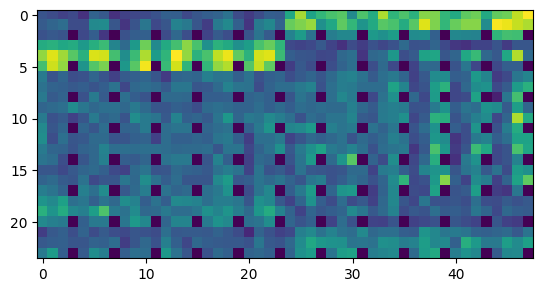

In [41]:
plt.imshow(tab)

In [43]:
column = [f'w{i:02}' for i in range(1,13) for j in range(1,5)]
index = ['A','A','A','B','B','B','C','C','C','D','D','D','E','E','E','F','F','F','G','G','G','H','H','H']

tab_df = pd.DataFrame(tab, index=index, columns=column)
tab_df.to_csv(f'{path}/nuclei_masks/cell_count.csv')


plt.figure(figsize=(24,16))
plt.imshow(tab, cmap='hot')
plt.xticks(range(0,48), column)
plt.yticks(range(0,32), index)
plt.savefig(f'{path}/../nuclei_masks/cell_count_heatmap.png', dpi=300)

OSError: Cannot save file into a non-existent directory: '../_DATA/Z factor test and starvation/3xZfactorand3xStarvation/1/2024-04-23/17999/TimePoint_1/nuclei_masks'

In [16]:
# site = range(1,17)
# well = range(1,3)
# plate = ['A', 'B']

# tab = np.zeros((8,8))

# for pl, p in enumerate(plate):
#     for w in well:
#         i, j = 0, 0
#         for s in site:
#             file_name = f'{p}{w:02}_s{s}_w'
            
#             w1 = read_image(file_path=path, file_name=f'{file_name}'+'1')
            
#             # Create a composit image by combining them
            
#             segmented = get_nuclei_segmentation(w1)

#             segmented = remove_border_objects(segmented)

#             segmented = remove_objects_outside_iqr(segmented)

#             contours, _ = cv.findContours((255*segmented).astype('uint8'), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            
#             print(f'{file_name} -> {len(contours)}')
            
#             row = ((pl)*4)+i
#             col = ((w-1)*4)+j
#             tab[row, col] = len(contours)
# #             print(row,col)
            
#             j+=1
            
#             if s%4==0:
#                 j=0
#                 i+=1


In [ ]:
tab

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(tab, cmap='hot')
plt.xticks(ticks=range(1,48,4), labels=['1','2','3','4','5','6','7','8','9','10','11','12'])
plt.yticks(ticks=range(1,32,4), labels=['A','B','C','D','E','F','G','H'])

In [ ]:
np.median(tab[:4,:4])

In [ ]:
tab[:4,:4]

In [ ]:
plt.imshow(tab)

In [ ]:
p = 'B'
w = 8
s = 6
file_name = f'{p}{w:02}_s{s}_w'
w1 = read_image(file_path=path, file_name=f'{file_name}'+'1')

plt.imshow(w1, cmap='gray')
plt.imshow(cv.equalizeHist((w1/256).astype('uint8')), cmap='gray')

In [ ]:
p = 'A'
w = 1
s = 1
file_name = f'{p}{w:02}_s{s}_w'
w1 = read_image(file_path=path, file_name=f'{file_name}'+'1')



plt.imshow(w1, cmap='gray')

# plt.imshow(cv.equalizeHist((w1/256).astype('uint8')), cmap='gray')

In [ ]:
plt.imshow(cv.equalizeHist(w1/256))

In [ ]:
plt.imshow(cv.equalizeHist((w1/256).astype('uint8')), cmap='gray')

In [ ]:
w1/256

In [ ]:
((w1-w1.min())/(w1.max()-w1.min())).astype('uint8')

In [ ]:
plt.imshow(cv.equalizeHist((255*((w1-w1.min())/(w1.max()-w1.min()))).astype('uint8')), cmap='gray')

In [ ]:
(255*((w1-w1.min())/(w1.max()-w1.min()))).astype('uint8')

In [ ]:
(w1/256).astype('uint8')

In [3]:
from dashai.processing import ExtractImageFeatures
from tqdm import tqdm
import tifffile

import string
import pandas as pd

In [4]:
# !ls ../../_CLEANED_DATA/magnification/10x/2024-11-20/plate_1

In [37]:
path = "../../_CLEANED_DATA/magnification/10x/2024-11-20"
folders = os.listdir(f'{path}')
for folder in folders:
    print(f'Processing: {folder}')
    files = os.listdir(f'{path}/{folder}')
    files = [file for file in files if file.split('.')[0].endswith('w1')]
    for file in tqdm(files):
        image_info = {
            'file_path': f'{path}/{folder}',
            'file_name': file,
            'row_alphabet': file.split("_")[1][0],
            'col_number': int(file.split("_")[1][1:]),
            'site': int(file.split("_")[2][1:]),
            'wavelength': int(file.split("_")[3].split('.')[0][1:])
            # 'image_dimension'
        }
        image = tifffile.imread(f'{path}/{folder}/{file}')
        image_features = ExtractImageFeatures()
        image_features.set_image(image)
        features = image_features.extract_all_features()
        print(image_info | features)
        break
    break

Processing: plate_1


  0%|                                                                                                                                                                                                                              | 0/192 [00:01<?, ?it/s]

{'file_path': '../../_CLEANED_DATA/magnification/10x/2024-11-20/plate_1', 'file_name': '10xPAYoungOldMixed_B03_s1_w1.tif', 'row_alphabet': 'B', 'col_number': 3, 'site': 1, 'wavelength': 1, 'laplacian': 92781.80859477536, 'tenengrad': 412.8927575012537, 'brenners_gradient': 25968980044, 'fourier_magnitude': 237.70919979753214, 'noise_level': 51.851510046762854, 'snr': 1.3272733816503626, 'mean_intensity': 1111.2848999500275, 'median_intensity': 981.0, 'std_intensity': 837.2690323738957, 'variance': 701019.4325723196, 'min_intensity': 0, 'max_intensity': 23066, 'dynamic_range': 23066, 'dynamic_range_utilization': 0.3519645990691997, 'bit_depth': 16, 'histogram': array([3, 0, 0, ..., 0, 0, 0]), 'entropy': 5.829543928941251, 'skewness': 7.31574343571543, 'kurtosis': 58.65476384534457, 'contrast': 24.123592425838233, 'dissimilarity': 1.2250411908213898, 'homogeneity': 0.6724672583088371, 'energy': 0.3817712958127488, 'correlation': 0.859390051906245, 'ASM': 0.14575312189177028, 'lbp_bin_0':

In [40]:
import csv
def write_image_info_to_csv(image_info, folder_path, csv_filename):
    """
    Writes the image_info dictionary to a CSV file.

    Parameters:
    - image_info (dict): Dictionary containing image information.
    - folder_path (str): Path to the folder where the CSV file will be created.
    """

    # Define the default CSV filename
    # csv_filename = 'image_info.csv'
    csv_path = os.path.join(folder_path, csv_filename)

    # Check if the file exists
    # if os.path.isfile(csv_path):
    #     # # If it exists, append date and time to the filename
    #     # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    #     # csv_filename = f'image_info_{timestamp}.csv'
    #     # csv_path = os.path.join(folder_path, csv_filename)

    with open(csv_path, mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=image_info.keys())
        
        # Write the header if the file is newly created
        if os.path.getsize(csv_path) == 0:
            writer.writeheader()

        # Write the image_info dictionary rows
        writer.writerow(image_info)

In [41]:
write_image_info_to_csv(image_info | features, path, 'plate_1.csv')

In [22]:
image_info | features

{'file_path': '../../_CLEANED_DATA/magnification/10x/2024-11-20/plate_1',
 'file_name': '10xPAYoungOldMixed_B03_s1_w1.tif',
 'laplacian': 92781.80859477536,
 'tenengrad': 412.8927575012537,
 'brenners_gradient': 25968980044,
 'fourier_magnitude': 237.70919979753214,
 'noise_level': 51.851510046762854,
 'snr': 1.3272733816503626,
 'mean_intensity': 1111.2848999500275,
 'median_intensity': 981.0,
 'std_intensity': 837.2690323738957,
 'variance': 701019.4325723196,
 'min_intensity': 0,
 'max_intensity': 23066,
 'dynamic_range': 23066,
 'dynamic_range_utilization': 0.3519645990691997,
 'bit_depth': 16,
 'histogram': array([3, 0, 0, ..., 0, 0, 0]),
 'entropy': 5.829543928941251,
 'skewness': 7.31574343571543,
 'kurtosis': 58.65476384534457,
 'contrast': 24.123592425838233,
 'dissimilarity': 1.2250411908213898,
 'homogeneity': 0.6724672583088371,
 'energy': 0.3817712958127488,
 'correlation': 0.859390051906245,
 'ASM': 0.14575312189177028,
 'lbp_bin_0': 0.15811419486999512,
 'lbp_bin_1': 0.1

In [7]:
# from bioio import BioImage
# import bioio_ome_tiff

# img = BioImage(f'{path}/{folder}/{file}', reader=bioio_ome_tiff.Reader)
# img.data

In [8]:
# !pip list

In [9]:
import sys
print(sys.executable)

/n/app/miniconda3/23.1.0/bin/python


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [10]:
# files

In [11]:
import matplotlib.pyplot as plt

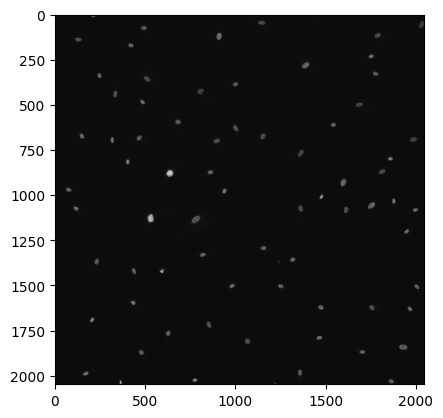

In [12]:
plt.imshow(image, cmap='gray')

In [13]:
int(file.split("_")[2][1:])%2

1

In [39]:
print(file)
print(f'plate: {file.split("_")[1][0]}')
print(f'well: {int(file.split("_")[1][1:])}')
print(f'site: {file.split("_")[2][1:]}')


    
# r = 

10xPAYoungOldMixed_B03_s1_w1.tif
plate: B
well: 3
site: 1


In [40]:
p

'B'

In [54]:
print('row: ', (string.ascii_uppercase.index(p)*site_row) + int(s)//site_row)
print('col: ', (((int(w)-1)*site_col) + int(s)%site_row))

row:  2
col:  5


In [51]:
(int(w)-1)*site_col

1

In [38]:
site_row

2

In [76]:
import string
import pandas as pd

In [96]:
def _get_index(row, site_multiple):
    index=[]
    for l in list(string.ascii_uppercase[:row]):
        for _ in range(site_multiple):
            index.append(l)
    return index

def _get_columns(col, site_multiple):
    columns=[f'w{i:02}' for i in range(1,col+1) for j in range(1,site_multiple+1)]
    return columns

def create_plate(well_count, site_row, site_col):
    if well_count == 96:
        row = 8
        col = 12

    total_row = row*site_row
    total_col = col*site_col

    plate = np.zeros((total_row, total_col))

    return plate

def _get_row_col(file_name, site_row, site_col):
    p = file_name.split("_")[1][0]
    w = int(file_name.split("_")[1][1:])
    s = file_name.split("_")[2][1:]

    return (p, w, s, ((string.ascii_uppercase.index(p)*site_row) + (int(s)-1)//site_row), (((int(w)-1)*site_col) + (int(s)-1)%site_row))

def add_axis(plate, well_count, site_row, site_col, savefig=False, fig_name=None):
    if well_count == 96:
        row = 8
        col = 12
    
    column = _get_columns(col, site_col)
    index = _get_index(row, site_row)

    tab_df = pd.DataFrame(plate, index=index, columns=column)
    # tab_df.to_csv(f'{path}/nuclei_masks/cell_count.csv')
    
    
    plt.figure(figsize=(len(column)//2,len(index)//2))
    plt.imshow(plate, cmap='hot')
    plt.xticks(range(0,len(column)), column)
    plt.yticks(range(0,len(index)), index)
    if savefig and fig_name is not None:
        plt.savefig(f'{fig_name}.png', dpi=300)
    
# create_plate(96, 4, 4)

In [86]:
plate.shape

(16, 24)

In [87]:
folder

'plate_1'

In [100]:
site_row = 2
site_col = 2

path = "../../_CLEANED_DATA/magnification/10x/2024-11-20"
# folders = os.listdir(f'{path}')
folders = ["plate_1"]
for folder in folders:
    print(f'Processing: {folder}')
    files = os.listdir(f'{path}/{folder}')
    files = [file for file in files if file.split('.')[0].endswith('w1')]

    plate_laplacian = create_plate(96, site_row, site_col)
    plate_tenengrad = create_plate(96, site_row, site_col)
    plate_brenners_gradient = create_plate(96, site_row, site_col)
    plate_fourier_magnitude = create_plate(96, site_row, site_col)
    
    for file in tqdm(files):
        _, _, _, r, c = _get_row_col(file, site_row, site_col)

        image = tifffile.imread(f'{path}/{folder}/{file}')
        sharpness = Sharpness()
        sharpness.set_image(image)
        features = sharpness.extract_all_features()
        plate_laplacian[r,c] = features['laplacian']
        plate_tenengrad[r,c] = features['tenengrad']
        plate_brenners_gradient[r,c] = features['brenners_gradient']
        plate_fourier_magnitude[r,c] = features['fourier_magnitude']
        # print(sharpness.extract_all_features())
        # break

Processing: plate_1


100%|█████████████████████████████████████████████████████████| 192/192 [01:48<00:00,  1.78it/s]


In [99]:
plate_laplacian

79459.48796997308

In [92]:
# sharpness.extract_all_features()

{'laplacian': 92781.80859477536,
 'tenengrad': 412.8927575012537,
 'brenners_gradient': 25968980044,
 'fourier_magnitude': 237.70919979753214}

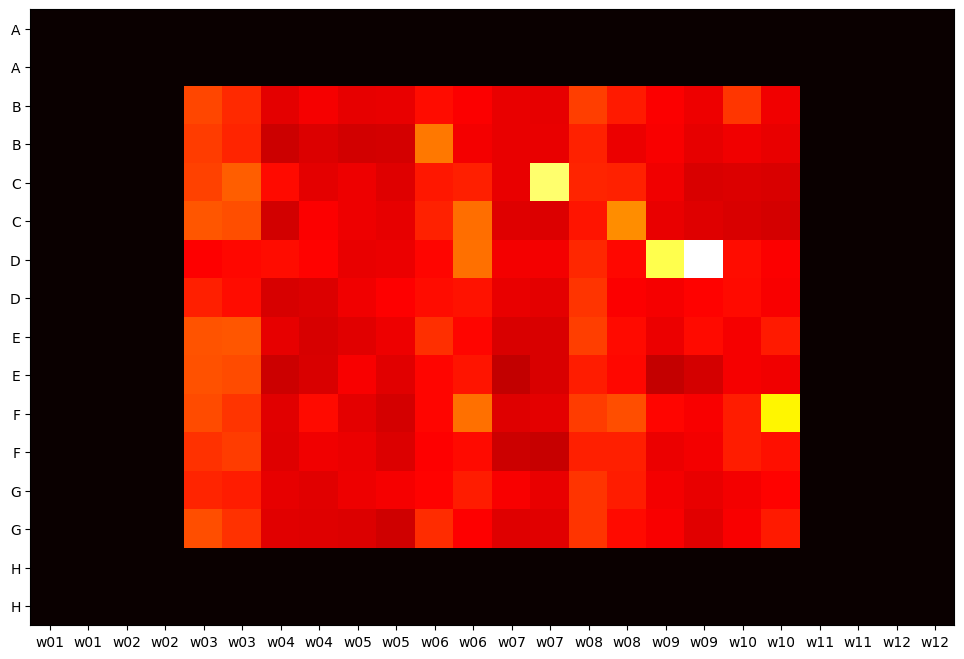

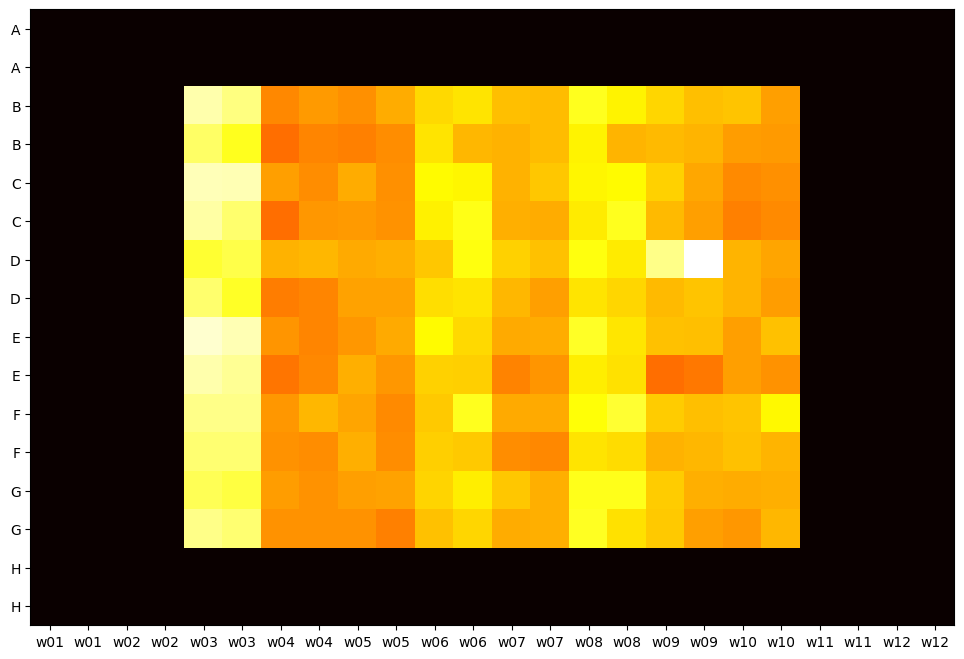

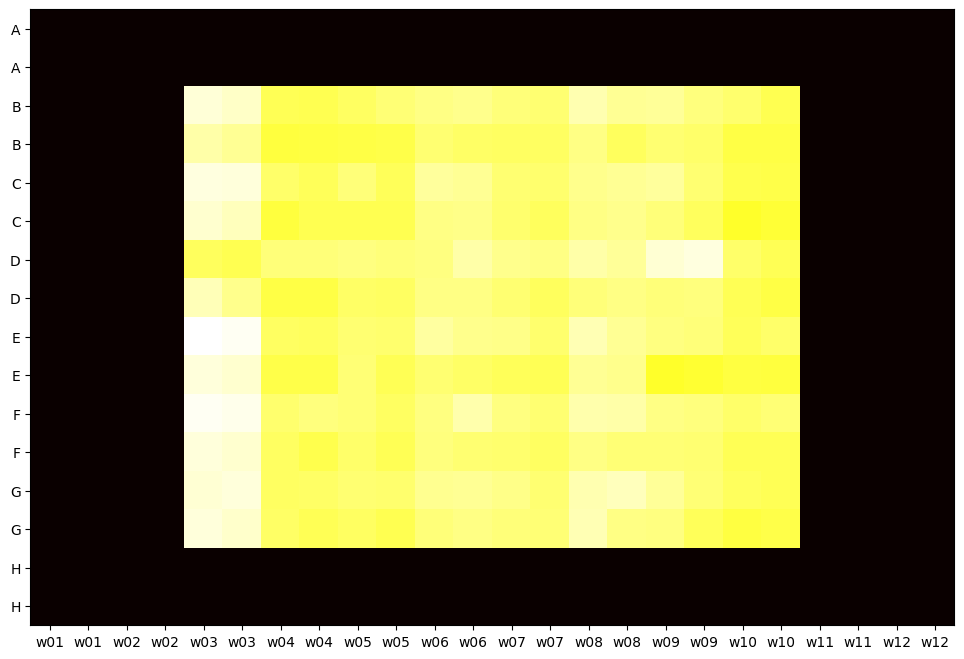

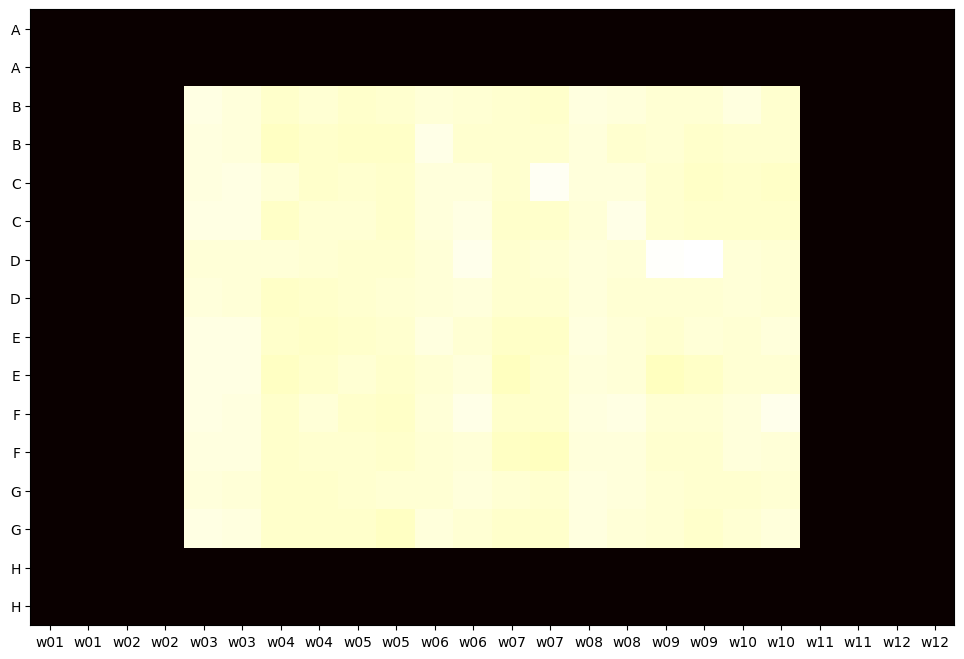

In [102]:
add_axis(plate=plate_laplacian, well_count=96, site_row=site_row, site_col=site_col, savefig=True, fig_name='laplacian')
add_axis(plate=plate_tenengrad, well_count=96, site_row=site_row, site_col=site_col, savefig=True, fig_name='tenengrad')
add_axis(plate=plate_brenners_gradient, well_count=96, site_row=site_row, site_col=site_col, savefig=True, fig_name='brenners_gradient')
add_axis(plate=plate_fourier_magnitude, well_count=96, site_row=site_row, site_col=site_col, savefig=True, fig_name='fourier_magnitude')

In [57]:
# well_count = 96
# site_row = 2
# site_col = 2
# skip_plates = ['A', 'H']
# skip_wells = [1, 2, 11, 12]

# plate = create_plate(96, 2, 2)

# if well_count == 96:
#     plate = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
#     well = range(1,13)

#     for pl, p in enumerate(plate):
#         for w in well:
#             if p not in skip_plates and w not in skip_wells:
#                 print(p,w, _get_row_col(file))

In [ ]:
site = range(1,13)
well = range(1,13)
plate = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

tab = np.zeros((24,48))
pre = os.listdir(path)[0].split('_')[0]

for pl, p in enumerate(plate):
    for w in well:
        print(p, w)
        i, j = 0, 0
        for s in site:
            file_name = f'{p}{w:02}_s{s}_w'
            
            w1 = read_image(file_path=path, file_name=f'{pre}_{file_name}1.tif')
            
            # Create a composit image by combining them
            
            segmented = segment_nuclei_stardist(w1)

            segmented = remove_border_objects(segmented)

#             segmented = remove_objects_outside_iqr(segmented)

            contours, _ = cv.findContours((255*segmented).astype('uint8'), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            
            img = display_image_with_overlay(w1, contours)
            
            row = ((pl)*3)+i
            col = ((w-1)*4)+j
            tab[row, col] = len(contours)
            
            j+=1
            
            if s%4==0:
                j=0
                i+=1

            cv.imwrite(f'{path}/../nuclei_masks/{file_name}.png', cv.cvtColor(img, cv.COLOR_BGR2RGB))